# Predict document classes using neural networks

## Install and Import required libraries

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm, trange


from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
import tensorflow as tf

tf.config.threading.set_inter_op_parallelism_threads(0)

from tensorflow import keras
from tensorflow.keras import layers

2022-12-08 17:27:30.144464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch and modify data

In [4]:
# train_image_dir = "/kaggle/input/datathonindoml-2022/train/train"
# valid_image_dir = "/kaggle/input/datathonindoml-2022/validation/validation"

train_image_dir = "../data/kaggle/train/train"
valid_image_dir = "../data/kaggle/validation/validation"

In [5]:
train_image_file_paths = [ os.path.join(train_image_dir, x) for x in os.listdir(train_image_dir)]
valid_image_file_paths = [ os.path.join(valid_image_dir, x) for x in os.listdir(valid_image_dir)]

In [6]:
xlabels = pd.read_csv('../data/kaggle/train_labels.csv')
xlabels.head(5)

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


In [7]:
def find_file_id(path):
    file_id = int((path.split("/")[-1]).split(".")[0])
    return file_id

def find_image_label(path):
    file_id = find_file_id(path)
    return (xlabels[xlabels.id==file_id]).values[0][1]


print("Path:", train_image_file_paths[0])
print("File ID:", find_file_id(train_image_file_paths[0]))
print("Label:", find_image_label(train_image_file_paths[0]))

Path: data/kaggle/train/train/13932.tif
File ID: 13932
Label: 1


In [8]:
y_labels = [find_image_label(x) for x in train_image_file_paths]
y_labels[:10]

[1, 0, 6, 5, 3, 2, 0, 3, 15, 7]

## Visualize data

Text(0.5, 1.0, 'Distribution of different classes')

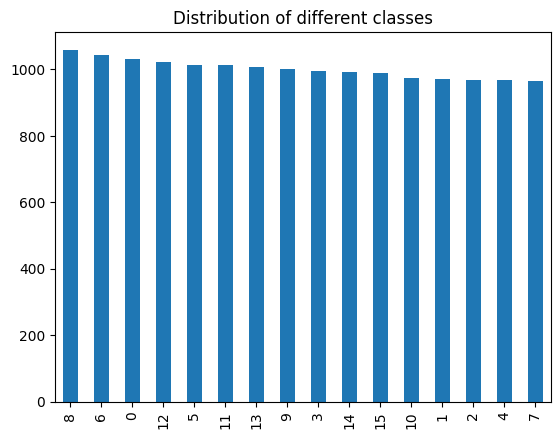

In [9]:
fig,ax = plt.subplots(figsize=(6.4,4.8),dpi=100)
ax =  xlabels['label'].value_counts().plot(kind="bar")
plt.title("Distribution of different classes")

data/kaggle/train/train/9133.tif (1000, 762) 13


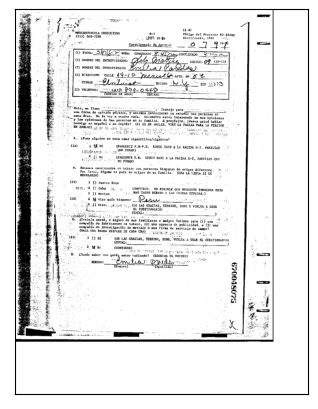

In [10]:
figure(figsize=(5, 5), dpi=100)
idx = 10
sample = train_image_file_paths[idx]
sample_img = io.imread(sample)
print(sample, sample_img.shape, y_labels[idx])
fig = plt.imshow(sample_img, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

In [11]:
len(train_image_file_paths), xlabels.shape[0]

(16000, 16000)

## Prepare and Split Data

In [12]:
def prep_train_feature_data(paths, dim=(100,100)):
    total=len(paths)
    x = np.zeros((total, dim[0], dim[1], 1), dtype='float')
    for i,path in (enumerate((paths))):
        img = io.imread(path)/255.0
        img =  resize(img, (dim[0], dim[1]))
        img = img.reshape((dim[0], dim[1]))
        x[i,:,:,0] = img
    return x

In [13]:
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, paths, batch_size=32, dim=(300, 300)):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.paths = paths

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.paths)//self.batch_size

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        index_start = idx*self.batch_size
        index_end = (idx+1)*self.batch_size

        sub_paths = self.paths[index_start:index_end]
        
        X = prep_train_feature_data(sub_paths, self.dim)
        y = [find_image_label(path) for path in sub_paths]

        return X, np.array(y)

In [14]:
n_classes=len(set(y_labels))
image_size = (300, 225)

In [15]:
from sklearn.model_selection import train_test_split
train_paths,valid_paths,train_labels,valid_labels = train_test_split(train_image_file_paths , y_labels , stratify = y_labels , test_size = 0.1, random_state=42)

In [16]:
train_paths,test_paths,train_labels,test_labels = train_test_split(train_paths , train_labels , stratify = train_labels , test_size = 0.15, random_state=42)

In [17]:
validation_data = prep_train_feature_data(valid_paths, image_size)
validation_preds = np.array(valid_labels)
validation = (validation_data, validation_preds)

In [18]:
test_data=prep_train_feature_data(test_paths,image_size)

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_process
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg_process

input_shape = image_size
input_shape = input_shape + (1,)
inputs = keras.Input(input_shape)

# image_augment_input = layers.RandomFlip()(inputs) 
# image_augment_input = layers.RandomRotation(factor=1.0)(image_augment_input)

## Create a CNN model and train

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import tensorflow.keras.callbacks
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import accuracy_score

inputs = keras.Input(shape=input_shape)
#layer1
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)
#layer2
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)
#layer3
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)
#layer4
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)
#layer5
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(16, activation="softmax")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 225, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 298, 223, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 298, 223, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 109, 64)      18496 

In [21]:
opt = Adam(learning_rate = 0.001)
model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

## Implement Early stopping, Checkpointing and adaptive learning reate

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# to retain the best model
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True #restoring the best model
                          )

# for adaptive learning rate
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              min_delta=0.001)

callbacks = [early_stopping,checkpoint,reduce_learningrate]

epochs = 20

In [35]:
train_generator = DataGenerator(train_paths, batch_size=64, dim=image_size)

In [36]:
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/20
191/191 [==============================] - 338s 2s/step - loss: 0.2170 - accuracy: 0.9388 - val_loss: 1.0519 - val_accuracy: 0.7331 - lr: 2.0000e-04
Epoch 2/20
191/191 [==============================] - 340s 2s/step - loss: 0.1692 - accuracy: 0.9535 - val_loss: 1.3360 - val_accuracy: 0.6794 - lr: 2.0000e-04
Epoch 3/20
191/191 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9629WARNING:tensorflow:Can save best model only with val_acc available, skipping.

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
191/191 [==============================] - 348s 2s/step - loss: 0.1395 - accuracy: 0.9629 - val_loss: 1.4697 - val_accuracy: 0.6631 - lr: 2.0000e-04
Epoch 4/20
191/191 [==============================] - 343s 2s/step - loss: 0.1122 - accuracy: 0.9718 - val_loss: 1.1237 - val_accuracy: 0.7306 - lr: 4.0000e-05
Epoch 4: early stopping


In [37]:
model.save("models/NeuralNetworks_cnn.h5")

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model("models/NeuralNetworks_cnn.h5")

## Post processing and Model metrics visualization

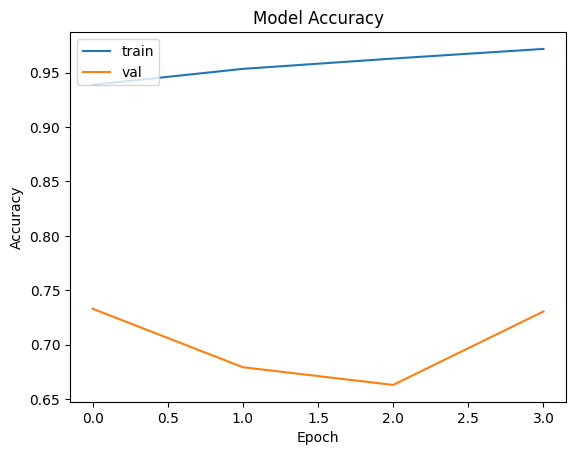

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

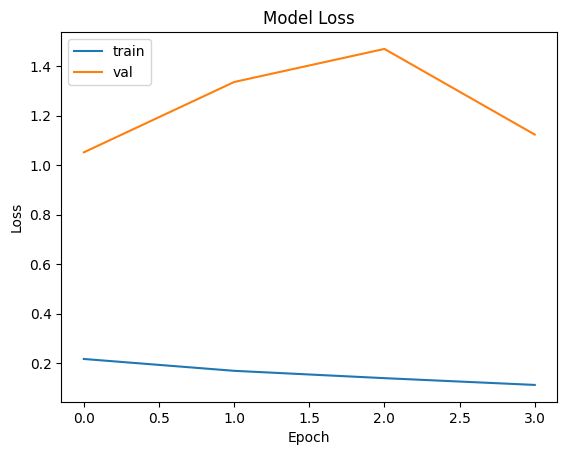

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
from sklearn.metrics import accuracy_score, classification_report

y_test_res = model.predict(test_data)
test_prediction = []
for i in range(test_data.shape[0]):
    idx = np.argmax(y_test_res[i])
    test_prediction.append(idx)

68/68 [==============================] - 15s 222ms/step


In [41]:
test_actual = np.array(test_labels)
accuracy = accuracy_score(test_actual,test_prediction)
print(accuracy)

0.7226851851851852


In [42]:
print(classification_report(test_actual,test_prediction))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       139
           1       0.59      0.53      0.56       131
           2       0.93      0.89      0.91       131
           3       0.88      0.86      0.87       134
           4       0.80      0.66      0.72       130
           5       0.49      0.53      0.51       137
           6       0.74      0.89      0.81       141
           7       0.86      0.68      0.76       130
           8       0.77      0.94      0.85       143
           9       0.57      0.77      0.66       135
          10       0.66      0.60      0.63       132
          11       0.75      0.69      0.72       136
          12       0.65      0.54      0.59       138
          13       0.64      0.70      0.67       136
          14       0.95      0.76      0.85       134
          15       0.74      0.74      0.74       133

    accuracy                           0.72      2160
   macro avg       0.73   

In [43]:
classes = list(range(16))
res = tf.math.confusion_matrix(test_prediction,test_actual).numpy()
cm = pd.DataFrame(res,
                     index = classes, 
                     columns = classes)

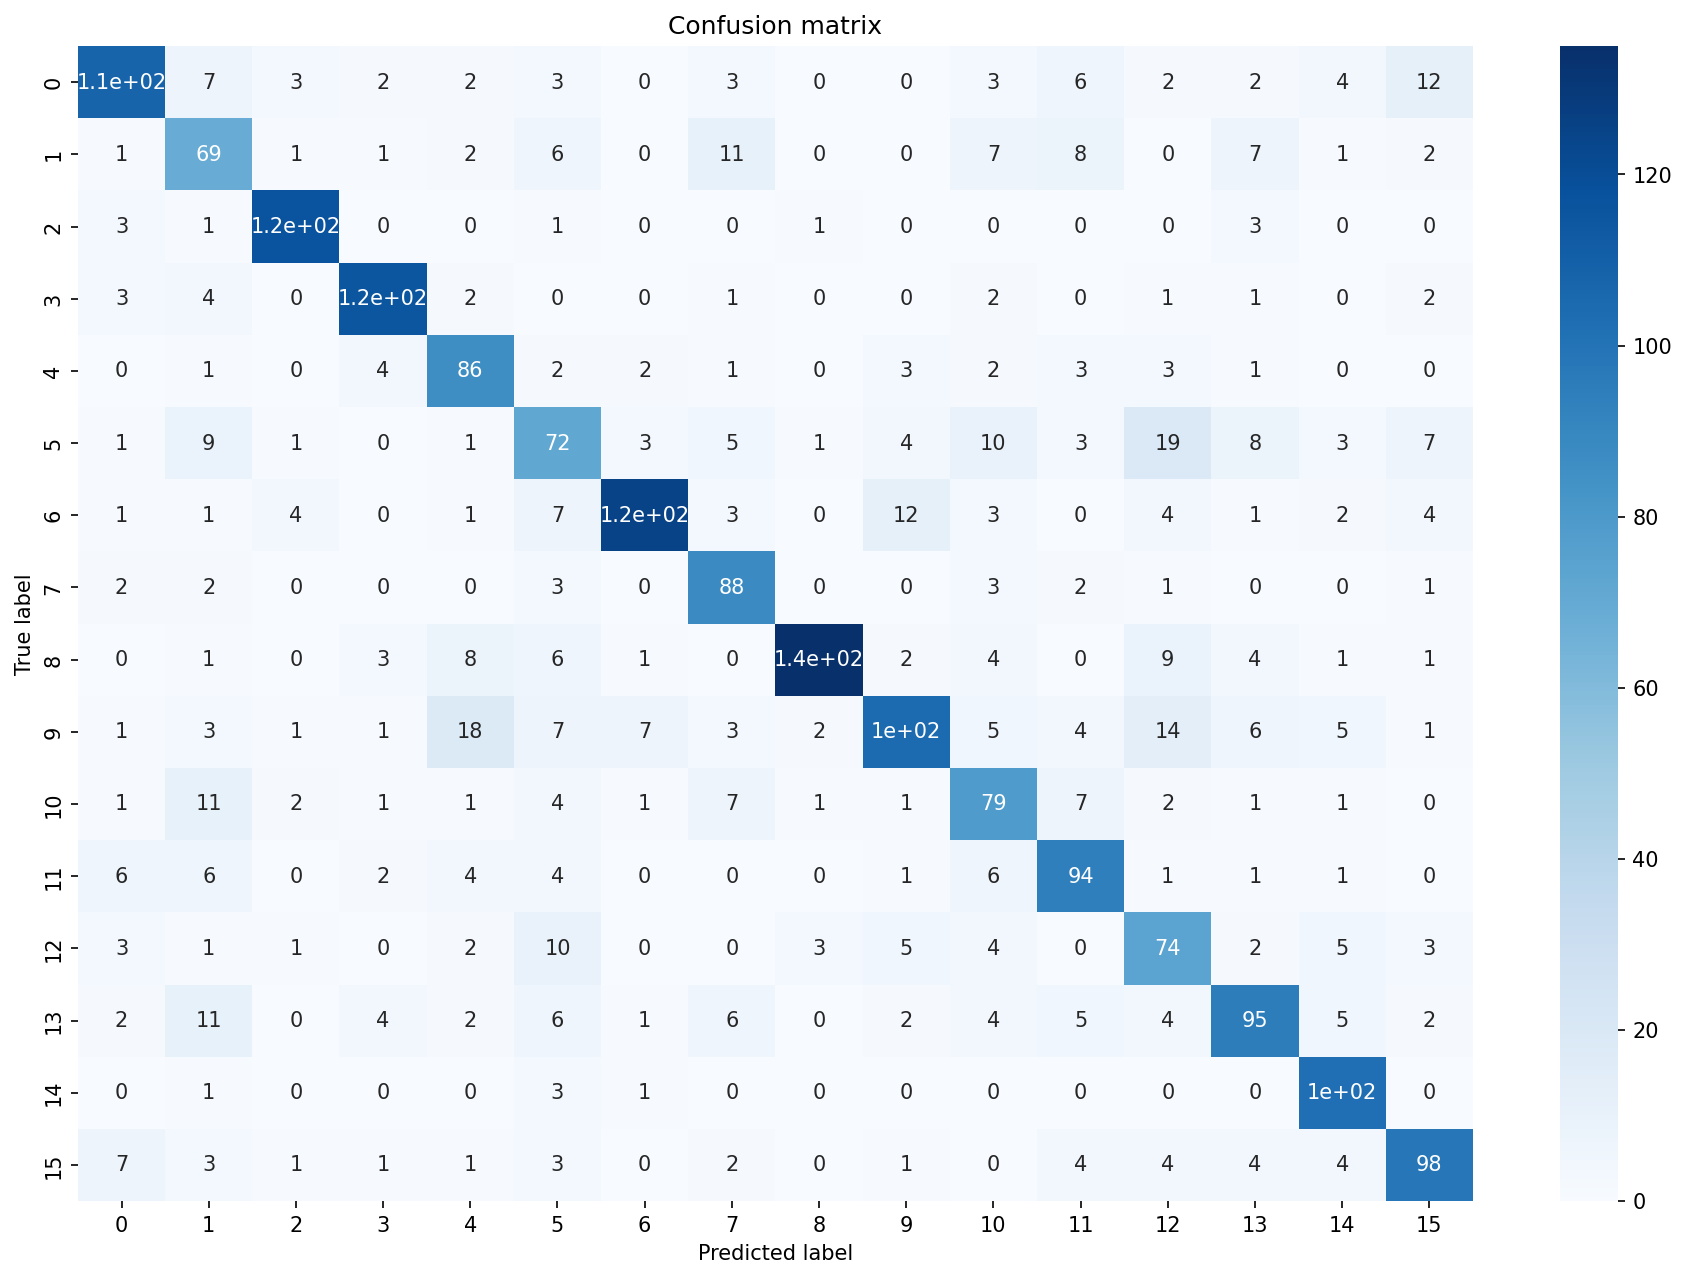

In [47]:
import seaborn as sns
figure = plt.figure(figsize=(15, 10), dpi=150)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()